# Redes neurais artificiais do zero em Python

Referência: Andrej Karpathy. The spelled-out intro to neural networks and backpropagation: building micrograd (2022). https://www.youtube.com/watch?v=VMj-3S1tku0

## Construindo um grafo computacional automaticamente

In [2]:
from graphviz import Digraph


def _tracar(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    vertices = set()
    arestas = set()

    def construir(v):
        """Função recursiva para traçar o grafo."""
        if v not in vertices:
            vertices.add(v)
            for progenitor in v.progenitor:
                arestas.add((progenitor, v))
                construir(progenitor)

    construir(folha)

    return vertices, arestas


def plota_grafo(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    grafo = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    vertices, arestas = _tracar(folha)

    for v in vertices:
        id_vertice = str(id(v))

        if hasattr(v, "rotulo") and (hasattr(v, "grad")):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f} | grad {v.grad:.3f}" + " }"

        elif hasattr(v, "rotulo"):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f}" + " }"

        else:
            texto = "{ " + f"data {v.data:.3f}" + " }"

        grafo.node(name=id_vertice, label=texto, shape="record")

        if v.operador_mae:
            grafo.node(name=id_vertice + v.operador_mae, label=v.operador_mae)
            grafo.edge(id_vertice + v.operador_mae, id_vertice)

    for vertice1, vertice2 in arestas:
        grafo.edge(str(id(vertice1)), str(id(vertice2)) + vertice2.operador_mae)

    return grafo

In [3]:
import math

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [4]:
a = Valor(10)
print(a)

Valor(data=10)


In [5]:
b = Valor(5)
print(b)

Valor(data=5)


In [6]:
c = a + b

In [7]:
print(c)

Valor(data=15)


In [8]:
c.progenitor

(Valor(data=10), Valor(data=5))

In [9]:
c.operador_mae

'+'

In [10]:
d = a * b

In [11]:
print(d)

Valor(data=50)


In [12]:
d.progenitor

(Valor(data=10), Valor(data=5))

In [13]:
d.operador_mae

'*'

In [14]:
b.progenitor

()

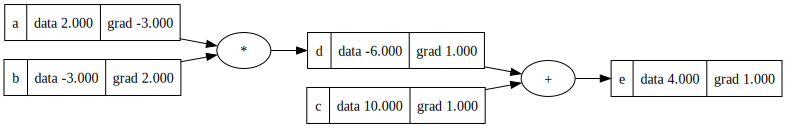

In [15]:
a = Valor(2, rotulo="a")
b = Valor(-3, rotulo="b")
c = Valor(10, rotulo="c")

d = a * b
d.rotulo = "d"
e = d + c
e.rotulo = "e"

e.grad = 1  # de/de
c.grad = 1  # de/dc   e = d + c
d.grad = 1  # de/dd

a.grad = -3  # de/da = 1 * -3   d = a * b
b.grad = 2  # de/db = 1 * 2

plota_grafo(e)

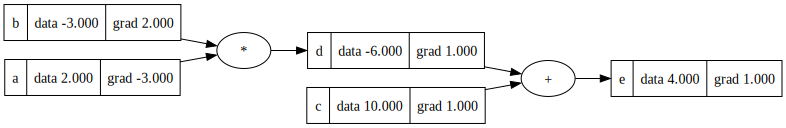

In [16]:
a = Valor(2, rotulo="a")
b = Valor(-3, rotulo="b")
c = Valor(10, rotulo="c")

d = a * b
d.rotulo = "d"
e = d + c
e.rotulo = "e"

e.propagar_tudo()

plota_grafo(e)

In [17]:
# autograd

![img](https://i.imgur.com/Q3MA6dZ.png)

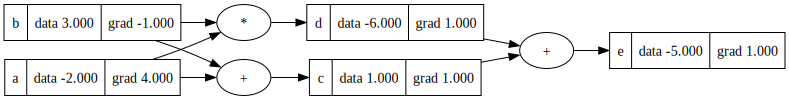

In [18]:
a = Valor(-2, rotulo="a")
b = Valor(3, rotulo="b")

c = a + b
d = a * b

e = c + d

c.rotulo = "c"
d.rotulo = "d"
e.rotulo = "e"

e.propagar_tudo()
plota_grafo(e)

In [19]:
a = Valor(10, rotulo="a")
b = a + 1
print(b)

Valor(data=11)


In [20]:
#1.data

In [21]:
a = Valor(10, rotulo="a")
b = a * 10
print(b)

Valor(data=100)


In [22]:
a = Valor(10, rotulo="a")
b = 1 + a
print(b)

Valor(data=11)


In [23]:
a = Valor(10, rotulo="a")
b = 10 * a
print(b)

Valor(data=100)


In [24]:
a = Valor(1, rotulo="a")
b = a.exp()  # exp(a) ~ 2.718
print(b)

Valor(data=2.718281828459045)


In [25]:
a = Valor(10, rotulo="a")
b = a**2
print(b)

Valor(data=100)


In [26]:
a = Valor(1, rotulo="a")
b = Valor(2, rotulo="b")
c = a / b
print(c)

Valor(data=0.5)


In [27]:
a = Valor(1, rotulo="a")
b = -a
print(b)

Valor(data=-1)


In [28]:
a = Valor(10, rotulo="a")
b = Valor(3, rotulo="b")
c = a - b
print(c)

Valor(data=7)


$$
S(x) = \frac{e^x}{e^x + 1}
$$

In [29]:
a = Valor(0, rotulo="a")
b = a.sig()
print(b)

Valor(data=0.5)


In [30]:
class Valor:
    def __init__(self,data,progenitor=(),operador_mae = "",rotulo = ""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0
        
    def __repr__(self):
        return f'Valor(data={self.data})'   
     
    def __add__(self,outro_valor):
        progenitor = (self,outro_valor)
        data =self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor,operador_mae)

        def propagar_adicao():
            self.grad = resultado.grad
            outro_valor.grad = resultado.grad
        
        resultado.propagar = propagar_adicao
        
        return resultado


    
    def __mul__(self,outro_valor):
        progenitor = (self,outro_valor)
        data =self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor,operador_mae)
        
        def propagar_multiplicacao():
            self.grad = resultado.grad * outro_valor.data
            outro_valor.grad = resultado.grad * self.data
        
        resultado.propagar = propagar_multiplicacao
        return resultado 
       
               
           
    def propagar(sef):
        pass 

In [31]:
a = Valor(6,rotulo="a")
b = Valor(10,rotulo="b")

In [32]:
a = Valor(-2, rotulo="a")
b = Valor(3, rotulo="b")

c = a + b
d = a * b

e = c + d

c.rotulo = "c"
d.rotulo = "d"
e.rotulo = "e"

e.grad = 1
e.propagar()
d.propagar()
c.propagar()

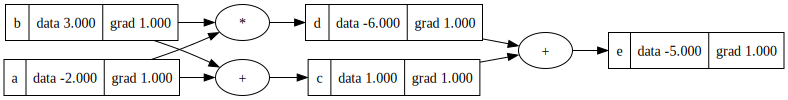

In [33]:
plota_grafo(e)

In [34]:
class uai:
    def __init__(self,n):
        self.n = n
    def __add__(self,b):
        return self.n+b 
    def __radd__(self,b):
        return b+self.n

In [35]:
a = uai(2)

In [36]:
a+3

5

In [37]:
3+a

5